In [690]:
import torch
import random
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from sklearn.model_selection import train_test_split
import pandas as pd

In [691]:
size = 256

In [692]:
class CatNet(nn.Module):
    def __init__(self, inputsize, outputsize):
        super().__init__()
        self.inputsize = inputsize
        self.outputsize = outputsize
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(1, 8, 10, stride=2),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            torch.nn.Conv2d(8, 16, 7, stride=2),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, 7, stride=2),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 4, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, 4, stride=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 256, 4, stride=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 512, 3, stride=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 1024, 2, stride=1),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(1024, 18)
        ) 
    def forward(self, x):
        return self.model(x)


In [693]:
train_dataset = torch.load("datasets/train.pt")
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=False)
train_dataloader_1 = torch.utils.data.DataLoader(train_dataset)
test_dataset = torch.load("datasets/test.pt")
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)
test_dataloader_1 = torch.utils.data.DataLoader(test_dataset)
result_dataset = torch.load("datasets/predict.pt")
result_dataloader_1 = torch.utils.data.DataLoader(result_dataset)

In [694]:
num_epochs = 40
learning_rate = 4e-3
weight_decay = 0.1
model = CatNet(16, 18)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
loss_history = []
epoch_loss_history = []

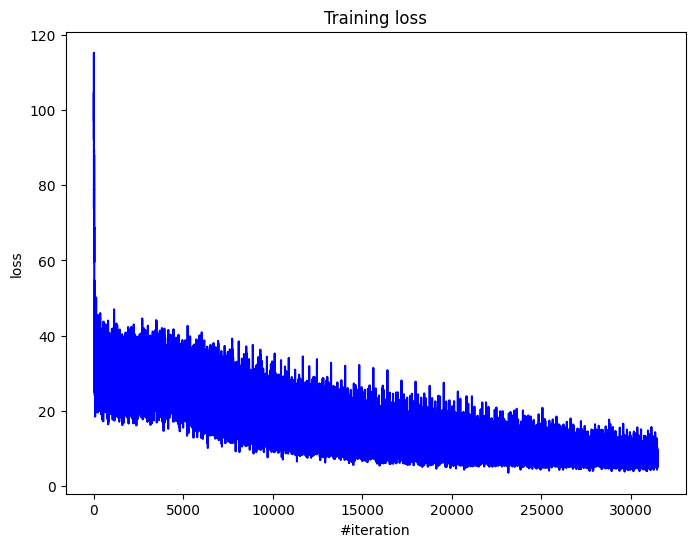

1/40 current loss: 19.067001342773438
2/40 current loss: 22.175703048706055
3/40 current loss: 20.475872039794922
4/40 current loss: 21.559165954589844
5/40 current loss: 19.620866775512695
6/40 current loss: 19.267763137817383
7/40 current loss: 19.516618728637695
8/40 current loss: 15.858793258666992
9/40 current loss: 14.827098846435547
10/40 current loss: 13.24437427520752
11/40 current loss: 12.435710906982422
12/40 current loss: 12.04517936706543
13/40 current loss: 10.002623558044434
14/40 current loss: 9.802116394042969
15/40 current loss: 10.301325798034668
16/40 current loss: 8.885355949401855
17/40 current loss: 7.494462966918945
18/40 current loss: 6.94106388092041
19/40 current loss: 7.157163619995117
20/40 current loss: 7.259058475494385
21/40 current loss: 5.817026138305664
22/40 current loss: 6.0136542320251465
23/40 current loss: 7.044130325317383
24/40 current loss: 6.221778869628906
25/40 current loss: 5.218507766723633
26/40 current loss: 5.71601676940918
27/40 curr

In [695]:
for i in range(num_epochs):
    for x_batch, y_batch in train_dataloader:
        predictions = model.forward(x_batch)
        
        loss = criterion(predictions, y_batch)

        # Backward
        loss.backward()

        # Update weights
        optimizer.step()
        optimizer.zero_grad() 

        loss_history.append(loss.item())
    epoch_loss_history.append(loss)
      
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    
    plt.show()

    for i in range(len(epoch_loss_history)):
        print(f'{i+1}/{num_epochs} current loss: {epoch_loss_history[i]}') 

In [696]:
torch.save(model.state_dict, 'weights/CatNet.pth')

In [697]:
model = CatNet(16, 18)
model.load_state_dict(torch.load('weights/CatNet.pth')())
model.eval()

CatNet(
  (model): Sequential(
    (0): Conv2d(1, 8, kernel_size=(10, 10), stride=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(7, 7), stride=(2, 2))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(7, 7), stride=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1

In [698]:
from sklearn.metrics import mean_absolute_error
real = []
pred = []
for x, y in train_dataloader_1:
    preds = model.forward(x)
    real.append(y[0].tolist())
    pred.append(preds[0].tolist())
print(f"MAE on train data : {mean_absolute_error(real, pred)}")
real = []
pred = []
for x, y in test_dataloader_1:
    preds = model.forward(x)
    real.append(y[0].tolist())
    pred.append(preds[0].tolist())
print(f"MAE on test data : {mean_absolute_error(real, pred)}")

MAE on train data : 11.599180967825356
MAE on test data : 16.909803545971652


C:\Users\Oleg\AppData\Local\Temp\ipykernel_12924\1514885454.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axs[num, i].plot(x,y, 'ro', color = 'blue')
C:\Users\Oleg\AppData\Local\Temp\ipykernel_12924\1514885454.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axs[num, i].plot(x,y, 'ro', color = 'blue')
C:\Users\Oleg\AppData\Local\Temp\ipykernel_12924\1514885454.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axs[num, i].plot(x,y, 'ro', color = 'blue')


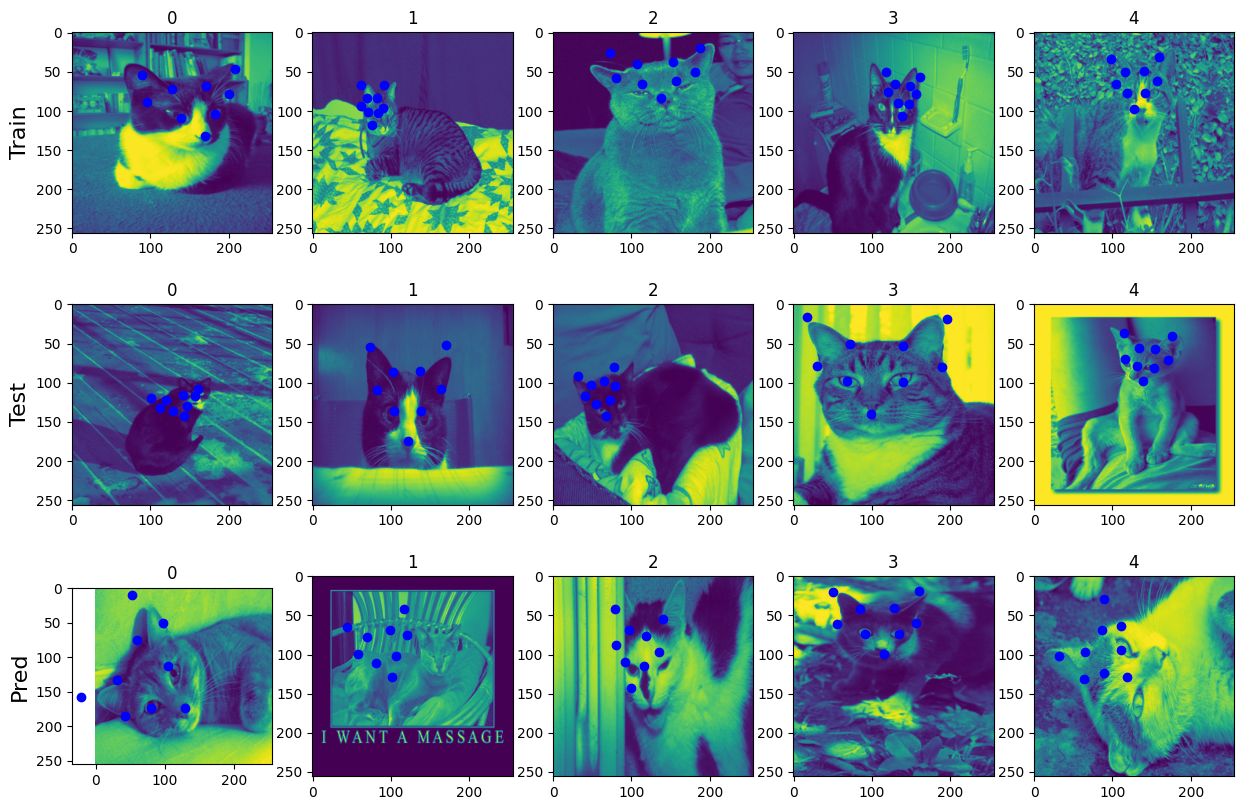

In [699]:
fig, axs = plt.subplots(nrows= 3 , ncols= 5,  figsize=(15,10))
cats_nums = range(5)
num = 0
axs[num,0].set_ylabel('Train', fontsize=16)
for i in cats_nums:
    x, y = train_dataset[i]
    axs[num, i].set_title(str(i))
    draw_img = x.type('torch.IntTensor')
    draw_points = model.forward(torch.stack([x]))[0].detach().numpy()
    axs[num, i].imshow(draw_img.permute(1,2,0))
    for j in range(0, len(draw_points),2):
                x, y = draw_points[j], draw_points[j+1] 
                axs[num, i].plot(x,y, 'ro', color = 'blue')
num = 1
axs[num,0].set_ylabel('Test', fontsize=16)
for i in cats_nums:
    x, y = test_dataset[i]
    axs[num, i].set_title(str(i))
    draw_img = x.type('torch.IntTensor')
    draw_points = model.forward(torch.stack([x]))[0].detach().numpy()
    axs[num, i].imshow(draw_img.permute(1,2,0))
    for j in range(0, len(draw_points),2):
                x, y = draw_points[j], draw_points[j+1] 
                axs[num, i].plot(x,y, 'ro', color = 'blue')
num = 2
axs[num,0].set_ylabel('Pred', fontsize=16)
for i in cats_nums:
    x = result_dataset[i][0]
    axs[num, i].set_title(str(i))
    draw_img = x.type('torch.IntTensor')
    draw_points = model.forward(torch.stack([x]))[0].detach().numpy()
    axs[num, i].imshow(draw_img.permute(1,2,0))
    for j in range(0, len(draw_points),2):
                x, y = draw_points[j], draw_points[j+1] 
                axs[num, i].plot(x,y, 'ro', color = 'blue')

In [700]:
import torch 
import pandas as pd
from PIL import Image 
from os import listdir
from os.path import isfile, join
import torchvision.transforms as transforms 
import pandas as pd
import matplotlib.pyplot as plt
import math

size1 = 128
size2 = 128
train_split_size = 0.3

def get_img_by_name(name):
    transform_with_size = transforms.Compose([ 
        transforms.PILToTensor(),
        transforms.Resize((size1, size2)) 
    ]) 
    transform_without_size = transforms.Compose([ 
        transforms.PILToTensor()
    ]) 
    for path in ['images/images/train/', 'images/images/test/']:
        if name in listdir(path):
            filename = join(path, name)
            if isfile(filename):
                image = Image.open(filename)
                width, height = image.size
                img_tensor_with_size = transform_with_size(image).type('torch.FloatTensor')
                img_tensor_without_size = transform_without_size(image).type('torch.FloatTensor')
                return img_tensor_with_size, img_tensor_without_size, width, height
            
def draw_img_by_name(name, model, axis, tittle = True):
    img_tensor_with_size, img_tensor_without_size, width, height = get_img_by_name(name)
    csv = pd.read_csv('train_labels.csv')
    x = img_tensor_with_size
    axis.set_title(name)
    draw_img = x.type('torch.IntTensor')
    draw_points = model.forward(torch.stack([x]))[0].detach().numpy()
    axis.imshow(draw_img.permute(1,2,0))
    for j in range(0, len(draw_points),2):
                x, y = draw_points[j], draw_points[j+1] 
                axis.plot(x,y, 'r*', color = 'blue')
                
    arr = csv.loc[csv['file_name'] == name].drop('file_name', axis = 1).values[0]
    if len(arr) > 0:
         for j in range(0, len(arr),2):
                x, y = arr[j]*(size/width), arr[j+1]*(size/height) 
                axis.plot(x,y, 'g*', color = 'green')



#from pythonUtils.drawing import draw_img_by_name
intresting_pictures = ['2a5e97796bb037c190f9eafe4fb60ac2.jpg', '0acec983f7d559f971a8e38b90847cd5.jpg', '0e977d2dcff9a4b5e8913fd8ae90a3cb.jpg', '2b5a1ddb0d4444cc06a293f98ea61a48.jpg', '2bcb4c75bc83ed168dde3150f2d1b982.jpg', '2e3946c777c6f0b7e99f5c86afd78b29.jpg', '3af893700f3cd3a4a5acb80043bb4dd2.jpg', '4aeea389f06b3c13c6a4821817d7c7ba.jpg', '4b234dcae2b8ab10206dc57665e8decd.jpg', '4d4d795d784f3a8d3d07479e0ac79073.jpg']
fig, axs = plt.subplots(nrows= (len(intresting_pictures)//3)+1, ncols= 3,  figsize=(15,10))

for i in range(len(intresting_pictures)):
    draw_img_by_name(intresting_pictures[i], model, axs[i//3,i%3])

In [701]:
pred = []
for x in result_dataloader_1:
    preds = model.forward(x[0])
    pred.append(preds[0].tolist())
predSizesNames = pd.read_csv('datasets/predictSizez&names.csv')

In [702]:
columns = pd.read_csv('train_labels.csv').columns
result = pd.DataFrame(columns=columns)

In [703]:
for row in range(len(pred)):
    width = predSizesNames.loc[row,'0']
    height = predSizesNames.loc[row,'0']
    for i in range(0, len(pred[row]),2):
            pred[row][i] = pred[row][i]*(width/size)
            pred[row][i+1] = pred[row][i+1]*(height/size)

In [704]:
for row in range(len(pred)):
    result.loc[-1] = pred[row]+[predSizesNames.loc[row,'2']]
    result.index = result.index + 1
    result = result.sort_index()

In [705]:
result = result.rename(columns={"file_name":"file_names"})

In [706]:
result.to_csv('results/result.csv',index=False)